---
---
---
# **Fake News Classification**
## Max Mager, Teo Förste, Vladislav Antonov | Prof. Dr. Grüttmüller | Mustererkennung SS25
---
---
---
![Alt-Text](./Bilder/Intro.png)
<small> Bild erstellt mit DALL-E </small>
---
---
---

## **Motivation**
---
---
---

# Trump says to stop visa abuses that undermine U.S. workers,"BATON ROUGE, La - U.S. President-elect Donald Trump on Friday pledged to stop companies from abusing the visa process for foreign workers in a way that undermines the labor market for Americans. Speaking at a rally in Baton Rouge, Louisiana, Trump said he had spent time during the presidential campaign with workers who were laid off but forced to train foreign hires brought in to replace them. “That’s actually demeaning,” Trump said. “We’re not going to let that happen any more.” Without naming companies, he said firms would withhold severance pay from the workers unless they trained their foreign replacements.     “One of my first executive orders will be to ask the Department of Labor to investigate all visa abuses that undermine jobs and wages to the American worker,” he said.


# Fake? Real? Unsicher?

---
---
---
# Inhaltsverzeichnis

1. Datasets  
2. Vergleich von One-Class-Methoden  
3. Hyperparameter Tuning – erklären und kurz zeigen  
4. NLP mit SpaCy, Training mit BERT (DistilBERT)  
5. Multiple logistische Regression  
6. Random Forest
7. Auswertung mit neuen Datensätzen und allgemeinen Modell
---
---
---

---
---
---
## **Datasets von *Huggingface* und *Kaggle***
---
---
---

In [175]:
import pandas as pd

# Deine Tabelle als DataFrame
data = {
    "Eigenschaften\\Dataset": ["Ersteller*in", "Veröffentlicht", "Einträge gerundet ~", "Zusammenstellung", "Quelle"],
    "Fake News Classification": ["Saurabh Shahane", "2021", "72000", "Reuters, Kaggle, McIntire, Buzzfeed", "[1]"],
    "fake_news": ["Gonzalo Álvarez", "2021", "41000", "Kaggle, Reuters", "[2]"],
    "fake-news-detection-dataset-English": ["Erfan Moosavi Monazzah", "2023", "44000", "Kaggle", "[3]"],
    "Fake News Detection": ["Bhavik Jikadara", "2024", "45000", "Unbekannt", "[4]"]
}

df = pd.DataFrame(data)

# Tabelle mit größerer Schrift anzeigen
def style_table(df):
    return df.style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('font-size', '14pt'), ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('font-size', '12pt'), ('padding', '10px')]
        }]
    ).set_properties(**{'text-align': 'center'})

style_table(df)


,Eigenschaften\Dataset,Fake News Classification,fake_news,fake-news-detection-dataset-English,Fake News Detection
0,Ersteller*in,Saurabh Shahane,Gonzalo Álvarez,Erfan Moosavi Monazzah,Bhavik Jikadara
1,Veröffentlicht,2021,2021,2023,2024
2,Einträge gerundet ~,72000,41000,44000,45000
3,Zusammenstellung,"Reuters, Kaggle, McIntire, Buzzfeed","Kaggle, Reuters",Kaggle,Unbekannt
4,Quelle,[1],[2],[3],[4]


<small>
- [1] Fake news classification (2023): Kaggle, [online] https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification [abgerufen am 06.06.2025]
- [2] GonzaloA/fake_news · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/GonzaloA/fake_news [abgerufen am 06.06.2025]
- [3] ErfanMoosaviMonazzah/fake-news-detection-dataset-English · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English [abgerufen am 06.06.2025]
- [4] Fake news detection (2023): Kaggle, [online] https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection [abgerufen am 08.06.2025]
</small>

In [173]:
#pip install "numpy<2.0" #uncomment on incompatiblity problems with numpy version

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

base_path = '../src/data'
datasets = {}

def read_titles(filepath, dataset_name):
    # Sonderbehandlung für den Datensatz "Saurabh Shahane - Fake_News_Classification"
    if dataset_name.lower() == 'saurabh shahane':
        try:
            df = pd.read_csv(filepath, sep=',', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            return []

    # Standardverarbeitung
    for sep in [',', ';', '\t']:
        try:
            df = pd.read_csv(filepath, sep=sep, engine='python', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            continue
    return []

# Lade alle Datasets ein
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    all_titles = []
    files = glob.glob(os.path.join(folder_path, '*'))

    for filepath in files:
        titles = read_titles(filepath, folder)
        all_titles.extend(titles)

    unique_titles = set(all_titles)
    datasets[folder] = unique_titles

# Berechne Übereinstimmungsmatrix
result = pd.DataFrame(index=datasets.keys(), columns=datasets.keys(), dtype=float)
dataset_names = list(datasets.keys())

for i, a in enumerate(dataset_names):
    for b in dataset_names[i+1:]:
        titles_a = datasets[a]
        titles_b = datasets[b]

        if len(titles_a) == 0:
            score_ab = 0.0
        else:
            inter_ab = len(titles_a.intersection(titles_b))
            score_ab = (inter_ab / len(titles_a)) * 100

        if len(titles_b) == 0:
            score_ba = 0.0
        else:
            inter_ba = len(titles_b.intersection(titles_a))
            score_ba = (inter_ba / len(titles_b)) * 100

        result.loc[a, b] = score_ab
        result.loc[b, a] = score_ba

for name in dataset_names:
    result.loc[name, name] = 100.0

result = result.round(2)


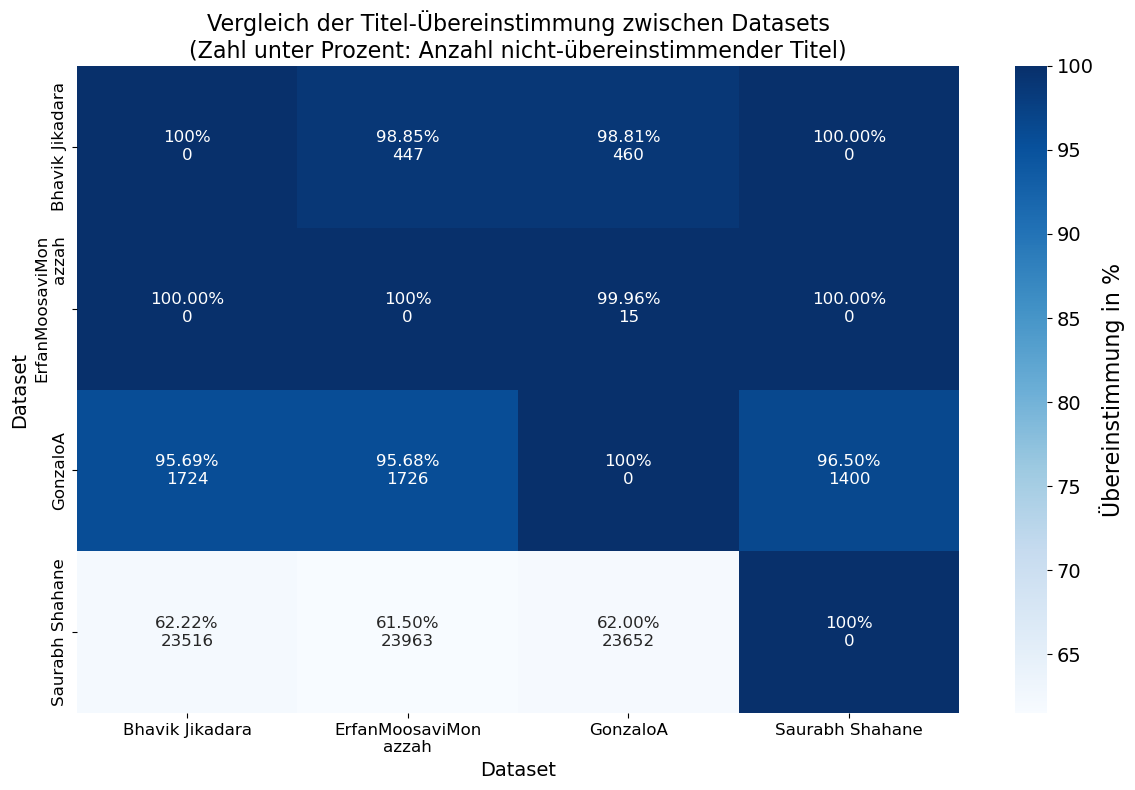

In [6]:
import textwrap

max_label_length = max(len(name) for name in dataset_names)
wrap_width = 15 if max_label_length > 15 else max_label_length

annot = result.copy().astype(str)
for i, a in enumerate(dataset_names):
    for j, b in enumerate(dataset_names):
        if a == b:
            annot.loc[a, b] = "100%\n0"
        else:
            titles_a = datasets[a]
            titles_b = datasets[b]
            unmatched_count = len(titles_a - titles_b)
            percent = result.loc[a, b]
            annot.loc[a, b] = f"{percent:.2f}%\n{unmatched_count}"

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    result,
    annot=annot.values,
    fmt="",
    cmap='Blues',
    cbar_kws={'label': 'Übereinstimmung in %'},
    annot_kws={"fontsize": 12}
)

# Colorbar-Schriftgröße anpassen
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(16)   # Größe für Label an der Colorbar (Übereinstimmung in %)
cbar.ax.tick_params(labelsize=14)  # Größe für die Zahlen an der Colorbar

wrapped_xticklabels = [textwrap.fill(name, width=wrap_width) for name in dataset_names]
wrapped_yticklabels = [textwrap.fill(name, width=wrap_width) for name in dataset_names]

ax.set_xticklabels(wrapped_xticklabels, fontsize=12, rotation=0, ha='center')
ax.set_yticklabels(wrapped_yticklabels, fontsize=12, va='center')

plt.title('Vergleich der Titel-Übereinstimmung zwischen Datasets\n(Zahl unter Prozent: Anzahl nicht-übereinstimmender Titel)', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Dataset', fontsize=14)

plt.tight_layout()
plt.show()



---
---
---
## **Max:
Varianten von one-class vergleichen
local outlier factor gewinnt kurz erklären 
hyperparameter Tuning (erklären und kurz zeigen)
Auswertung mit verschiedenen Datensätzen
Vergleich durch benutzung von allen Kombinationen von Datensätzen
auf Modell mit besten Trainingsdaten**
---
---
---


---
---
---
## **Teo**
Ansatz: NLP mit SpaCy, Training mit BERT (DistilBert)  
Genauigkeit (F1):
- Gonzalo nach 1 Epoche: 98,46 %
- Saurabh nach 2 Epochen: 98,87 %  

TODO:
- restliche Datensätze trainieren
- Hyperparameteranpassung
- testen gegen unbekannte Daten
---

# Natural Language Processing angewandt auf Saurabh Shahane
___

In [ ]:
pip install torch

In [ ]:
pip install transformers

In [ ]:
# Imports
import pandas as pd
import spacy
import torch
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from datasets import Dataset
from pandarallel import pandarallel

In [ ]:
# Version Checks
print("Pandas version:", pd.__version__)
print("SpaCy version:", spacy.__version__)
print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)
print("Cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Initialize Parallelization
pandarallel.initialize(progress_bar=True)

In [ ]:
# Data Path
csv_path = "../src/data/Saurabh Shahane - Fake_News_Classification/WELFake_Dataset.csv"

# Read with semicolon separator
df = pd.read_csv(csv_path, sep=',')

# Split Data
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

# Quick sanity check
print("Train:", df_train.shape)
print("Eval: ", df_val.shape)
print("Test: ", df_test.shape)

# first 5 rows of dataset
print(df_train.head(5))

In [ ]:
# Define Preprocessing
def preprocess_text(text):
    import spacy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [ ]:
# Test Preprocessing (can be skipped)
df_train_sample = df_train[:5]['text'].astype(str).apply(preprocess_text)

with pd.option_context('display.max_colwidth', None):
    print(df_train_sample)

In [ ]:
# Apply Preprocessing
df_train['text'] = df_train['text'].astype(str).parallel_apply(preprocess_text)
df_test['text'] = df_test['text'].astype(str).parallel_apply(preprocess_text)

print(df_train['text'].head(5))

In [ ]:
# Load Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenizing
train_encodings = tokenizer(list(df_train['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(df_test['text']), truncation=True, padding=True)

In [ ]:
# Translate to Huggingface Dataset Format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': list(df_train['label'])
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': list(df_test['label'])
})

# Load Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Training Parameters
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Define Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1": report["weighted avg"]["f1-score"]
    }

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start Training
trainer.train()

# Evaluation
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)
print(classification_report(df_test['label'], pred_labels))

---
---
---

# Multiple Logistische Regression
___

- Anwendung auf nominalskalierte Kriterien
  - in unserem Fall binär logistisch --> Real = 0 oder Fake = 1 (oder andersherum)
- mehrere Prädiktoren bestehend aus Verknüpfung von Titel + Text
- sagt aus wie wahrscheinlich Real oder Fake
- Feature-Dimension wird durch TfidfVectorizer erstellt

Die allgemeine Formel der multiplen logistischen Regression lautet:

$$
P(Y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}^\top \boldsymbol{\beta}}}
$$

- **$\mathbf{x} = (x_1, x_2, \dots, x_n)$**  
  Merkmalsvektor eines Artikels, erstellt mit `TfidfVectorizer`.  
  Jeder Eintrag $x_i$ ist der TF-IDF-Wert eines bestimmten Wortes aus Titel und Text.

- **$\boldsymbol{\beta} = (\beta_0, \beta_1, \dots, \beta_n)$**  
  Regressionskoeffizienten des Modells.  
  $\beta_i$ gibt an, wie stark das Merkmal $x_i$ (ein Wort) zur Vorhersage "Fake News" beiträgt.

- **$\beta_0$**  
  Bias-Term (Grundwahrscheinlichkeit ohne Einfluss der Merkmale).

> **Beispiel:**  
> Wenn "clickbait" im Artikel nicht vorkommt ($x_1 = 0$) und "vaccine" häufig ($x_2 = 0{,}15$), dann fließen diese Werte gewichtet durch $\beta_1$, $\beta_2$ in die Entscheidung ein.

**Ziel:**  
Schätzung der Wahrscheinlichkeit, dass ein Artikel Fake News ist





<small>Multiple regression (o. D.): [Studyflix] https://studyflix.de/statistik/multiple-regression-2149 [abgerufen am 09.06.2025].</small>

___
## Term Frequency-Inverse Document Frequency (TF-IDF) Vektorisierer
___

- Verfahren zur Gewichtung von Wörtern in Texten
- Textklassifikation, Information Retrieval, Themenmodellierung

### TF
- TF(t, d) = (Anzahl von t in d) / (Gesamtanzahl Wörter in d)
  - t: Term/Wort
  - d: Dokument 
- Ziel: Häufige Begriffe im Dokument hervorheben.

### IDF
- IDF(t) = log((N + 1) / (df(t) + 1)) + 1
    - N:     Gesamtanzahl Dokumente
    - df(t): Anzahl Dokumente, die den Begriff t enthalten
-Ziel: Häufige Begriffe im Korpus abwerten (z. B. „the“, „and“).

### Tensorflow
- Tensorflow hat dafür öffentliche Bibliothek bereitgestellt
- verschiedene Parameter wie Featuregröße, Normalsierungen, Sprache..

<small>Anurag (2024): TF-IDF Vectorizer explained - Anurag - medium, in: Medium, 27.11.2024, [online] https://medium.com/@gusainanurag58/tf-idf-vectorizer-explained-373b3f07d23b.</small>

___
# Multiple Logistische Regression angewandt auf Welfake
___

In [125]:
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifier and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities
from sklearn.pipeline import Pipeline

In [127]:
csv_path = "../src/data/Saurabh Shahane/WELFake_Dataset.csv"

# Read with semicolon separator
df = pd.read_csv(csv_path, sep=',')

# Erstes Split: Training + Temp (Eval+Test)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Zweites Split: Eval + Test aus dem Temp-Set
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

In [128]:
# Merge text fields
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Define X and y
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # y_test only for evaluation

In [129]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=40_000,    # Keep only the top 40,000 most frequent terms to limit dimensionality
    ngram_range=(1,2),      # Include both unigrams (single words) and bigrams (pairs of words)
    stop_words='english',   # Remove common English stop words (e.g., 'the', 'and')
    lowercase=False
)

# Fit the vectorizer on the training data and transform texts to sparse matrices
# fit_transform learns the vocabulary from X_train and then transforms X_train
X_train_tfidf = vectorizer.fit_transform(X_train)

# Use the already-fit vectorizer to transform validation and test sets
# transform uses the learned vocabulary to convert new texts into vectors
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [130]:
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=40000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [131]:
# Generate predictions on the test set using our trained pipeline
# `test_preds` will be an array of predicted labels: 0 = real, 1 = fake
test_preds = pipeline.predict(X_test)

# If the true labels for the test split (`y_test`) are available, evaluate performance:
# Print overall accuracy to see the fraction of correct predictions
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Print a detailed classification report (precision, recall, F1-score) for each class
print(classification_report(
    y_test,             # True labels
    test_preds,         # Predicted labels
    target_names=['Real','Fake']
))

Test Accuracy: 0.9623879493577303
              precision    recall  f1-score   support

        Real       0.97      0.95      0.96      5255
        Fake       0.95      0.97      0.96      5566

    accuracy                           0.96     10821
   macro avg       0.96      0.96      0.96     10821
weighted avg       0.96      0.96      0.96     10821



In [132]:
# Create a DataFrame pairing each test article with its predicted label
submission = pd.DataFrame({
    'text': df_test['text'],            # Raw text from the test set
    'predicted_label': test_preds       # Model output: 0 = real, 1 = fake
})
# Export the predictions to CSV for review or submission (no index column)
submission.to_csv('fake_news_predictions.csv', index=False)

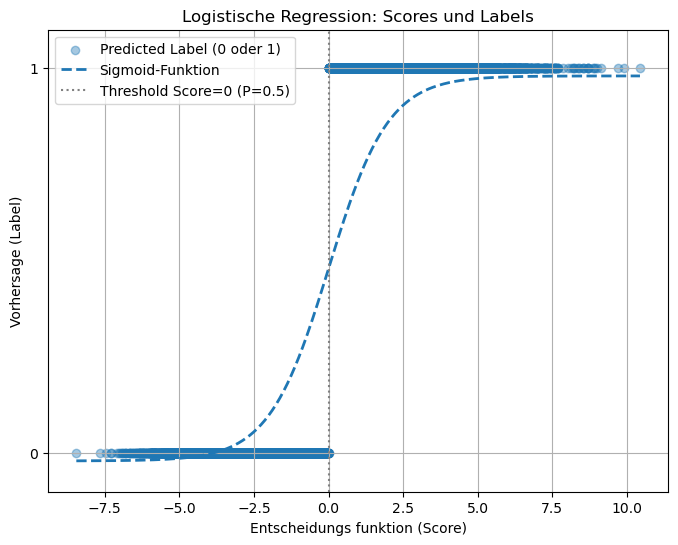

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Entscheidungsscores und Vorhersagen für die Validierungsdaten
dec_scores  = pipeline.decision_function(X_val)   # Roh-Score (logits)
pred_labels = pipeline.predict(X_val)             # Labels: 0 oder 1

plt.figure(figsize=(8, 6))

# Punkte: Score vs. Label
plt.scatter(dec_scores, pred_labels, alpha=0.4, label='Predicted Label (0 oder 1)')

# Ideale Sigmoid-Kurve
x = np.linspace(dec_scores.min(), dec_scores.max(), 300)
sigmoid = 1 / (1 + np.exp(-x))
# Verschiebung der Kurve um –0.02, damit sie nicht genau auf den Punkten liegt
plt.plot(x, sigmoid - 0.02, linestyle='--', linewidth=2, label='Sigmoid-Funktion')

# Threshold-Linie bei Score = 0 (entspricht P=0.5)
plt.axvline(0, color='gray', linestyle=':', label='Threshold Score=0 (P=0.5)')

plt.yticks([0, 1])
plt.ylim(-0.1, 1.1)
plt.xlabel('Entscheidungs funktion (Score)')
plt.ylabel('Vorhersage (Label)')
plt.title('Logistische Regression: Scores und Labels')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


___
# Random Forest
___

![Alt-Text](./Bilder/random-forest.jpg)

<small> Anas Brital | Random Forest algorithm explained . (o. D.): [online] https://anasbrital98.github.io/blog/2021/Random-Forest/ [abgerufen am 09.06.2025]. </small>

- **Anwendung auf nominalskalierte Kriterien, Mehrere Prädiktoren und Angabe einer Wahrscheinlichkeit wie bei Logistic Regression**

- **Zusammenstellung aus vielen Entscheidungsbäumen**  
  - Jeder Baum $h_t$ trifft eine Ja/Nein-Entscheidung („Real“ vs. „Fake“) basierend auf Schwellwerten der TF-IDF-Merkmale  
  - Die Bäume werden auf zufälligen Teilmengen von Daten und Features trainiert


#### Formel: Vorhersagewahrscheinlichkeit im Random Forest

$$
P(Y = 1 \mid \mathbf{x})
= \frac{1}{T} \sum_{t=1}^{T} h_t(\mathbf{x})
$$

- $\mathbf{x} = (x_1, x_2, \dots, x_n)$  
  Merkmalsvektor eines Artikels, erstellt mit `TfidfVectorizer`.

- $T$ = Anzahl der Entscheidungsbäume im Wald  
- $h_t(\mathbf{x}) \in \{0,1\}$ = Vorhersage des $t$-ten Baums (0 = Real, 1 = Fake)


#### Ziel:
Schätzung der Wahrscheinlichkeit, dass ein Artikel Fake News ist – basierend auf dem Votum vieler Entscheidungsbäume.


___
# Random Forest Regression angewandt auf Welfake
___

In [102]:
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifier and evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities (optional)
from sklearn.pipeline import Pipeline

In [104]:
csv_path = "../src/data/Saurabh Shahane/WELFake_Dataset.csv"

# Read with semicolon separator
df = pd.read_csv(csv_path, sep=',')

# Erstes Split: Training + Temp (Eval+Test)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Zweites Split: Eval + Test aus dem Temp-Set
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

In [105]:
# Merge text fields
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Define X and y
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # y_test only for evaluation

In [106]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=40_000,    # Keep only the top 20,000 most frequent terms to limit dimensionality
    ngram_range=(1,2),      # Include both unigrams (single words) and bigrams (pairs of words)
    stop_words='english',    # Remove common English stop words (e.g., 'the', 'and')
    lowercase=False
)

# Fit the vectorizer on the training data and transform texts to sparse matrices
# fit_transform learns the vocabulary from X_train and then transforms X_train
X_train_tfidf = vectorizer.fit_transform(X_train)

# Use the already-fit vectorizer to transform validation and test sets
# transform uses the learned vocabulary to convert new texts into vectors
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [107]:
pipeline = Pipeline([
    ('tfidf', vectorizer),                  # transform raw text to TF-IDF features
    ('clf', RandomForestClassifier(
        n_estimators=100,                   # number of trees in the forest
        max_depth=None,                      # allow trees to grow until all leaves are pure
        random_state=42                      # ensure reproducibility
    ))
])

# Train the Random Forest pipeline on the training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=40000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [108]:
# Generate predictions on the test set using our trained pipeline
# `test_preds` will be an array of predicted labels: 0 = real, 1 = fake
test_preds = pipeline.predict(X_test)

# If the true labels for the test split (`y_test`) are available, evaluate performance:
# Print overall accuracy to see the fraction of correct predictions
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Print a detailed classification report (precision, recall, F1-score) for each class
print(classification_report(
    y_test,             # True labels
    test_preds,         # Predicted labels
    target_names=['Real','Fake']
))

Test Accuracy: 0.965345162184641
              precision    recall  f1-score   support

        Real       0.98      0.95      0.96      5255
        Fake       0.95      0.98      0.97      5566

    accuracy                           0.97     10821
   macro avg       0.97      0.96      0.97     10821
weighted avg       0.97      0.97      0.97     10821



---
---
---
## **Max:
Auswertung mit verschiedenen Datensätzen
Vergleich durch benutzung von allen Kombinationen von Datensätzen
auf Modell mit besten Trainingsdaten**

---
---
---